# DKRZ tutorial

# CDO: Compute the climatology, anomalies, and standardized anomalies

In this notebook we calculate the **climatology**, the **multi-year monthly standard deviation** of the data and finally the **standardized anomaly** with **CDO (Climate Data Operators)**.

The calculation is shown here step by step and at the end we show how everything can be done with CDO in a single call.

**Learning content**

+ compute the climatology
+ compute the anomalies in one step
+ compute the multi-year monthly standard deviation
+ compute the standardized anomalies in one step

**Definitions**

    Climatology:
       The climatology is the average for a 30-years time range of a variable.
       The reference time period is set to 1991-2020.

    Anomaly:
       The anomaly (deviation from the mean) is the difference between the data 
       and the climatology (averaged data).
    
    Standardized anomaly:
       Standardized anomalies, or normalized anomalies, are calculated by 
       dividing the anomalies by the climatological standard deviation of the data.
<br>

2022 copyright DKRZ, kmf

----

In [1]:
from cdo import *
cdo = Cdo()

import xarray as xr
import os

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
%matplotlib inline

----

# Set time step for plotting

In [3]:
t = 0

----

# Data set

In [4]:
dir_path = os.environ['HOME']+'/data/CMIP6/LR/Temperature_Surface/Runs/ssp585/'
infile = dir_path + 'ssp585_em_LR_temp_1995-2100.nc'

In [5]:
ds = xr.open_dataset(infile)

In [6]:
data = ds.tas
data.shape

(1272, 96, 192)

Let's have a look at the original data for the chosen time step.

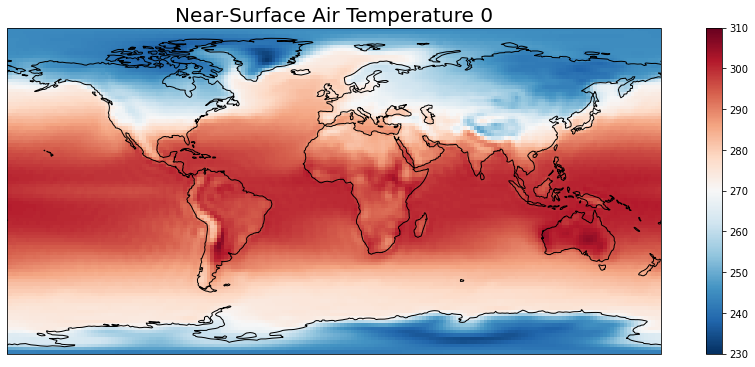

In [7]:
fig, ax = plt.subplots(figsize=(16,6), 
                       subplot_kw={"projection": ccrs.PlateCarree()})
ax.coastlines()
plot = ax.pcolormesh(ds.lon, ds.lat, data[t,:,:], 
                     cmap='RdBu_r', 
                     vmin=230., 
                     vmax=310.)
plt.title(ds.tas.long_name+' '+str(t), fontsize=20)
plt.colorbar(plot)

----

# Compute the climatology

The climatology is the average for a 30-years time range of a variable. To compute the climatology we use the time range 1981-2010 and the CDO operator **ymonavg** (CDO computes the weighted averages).

Set the reference time.

In [8]:
ref_time = ['1991-01-01', '2020-12-31']

Compute the climatology.

In [9]:
ds_clim = cdo.ymonavg(input='-seldate,'+ref_time[0]+','+ref_time[1]+' '+infile, returnXDataset=True)

In [10]:
clim = ds_clim.tas
clim.shape

(12, 96, 192)

----

# Compute the anomalies in one step

The anomaly is the difference between the raw and the averaged data (climatology).

```
anom = data - climatology
```

In [11]:
ds_anom = cdo.ymonsub(input=infile+' -ymonavg -seldate,'+ref_time[0]+','+ref_time[1]+' '+infile, returnXDataset=True)

In [12]:
anom = ds_anom.tas
anom.shape

(1272, 96, 192)

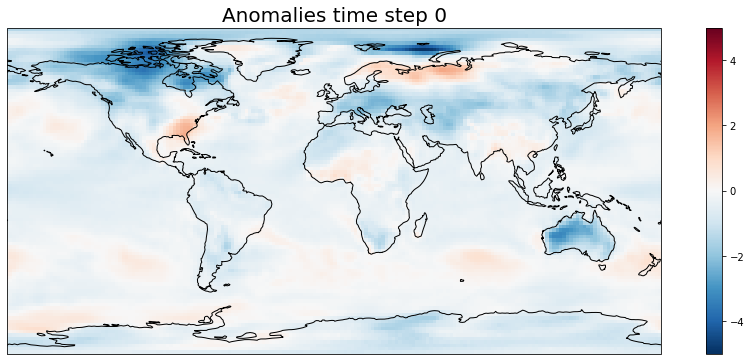

In [14]:
fig, ax = plt.subplots(figsize=(16,6), 
                       subplot_kw={"projection": ccrs.PlateCarree()})
ax.coastlines()
plot = ax.pcolormesh(ds_anom.lon, ds_anom.lat, anom[t,:,:], 
                     cmap='RdBu_r', 
                     vmin=-5., 
                     vmax=5.)
plt.title('Anomalies time step '+str(t), fontsize=20)
plt.colorbar(plot)

---- 
# Compute the multi-year monthly standard deviation

To compute the multi-year monthly standard deviation of the data we use the CDO operator **ymonstd**. It is needed to compute the standardized anomalies.


In [15]:
ds_std = cdo.ymonstd(input=infile, returnXDataset=True)

In [16]:
std = ds_std.tas
std.shape

(12, 96, 192)

----

# Compute the standardized anomalies in one step

CDO is able to compute the standardized anomalies in one step due to its ability of operator chaining (the results of each single operator execution is piped to the next one, from right to the left. We choose this time to return an Xarray Dataset used for plotting.

The Standardized anomalies, or normalized anomalies, are calculated by dividing the anomalies by the climatological standard deviation of the variable.

The standardized anomalies are often used to better understand the data when seasonal variations are present.

```
standardized anomaly = (data - climatology) / standard deviation of data
```


In [17]:
ds = cdo.ymondiv(input=' -ymonsub '+infile+' -ymonavg -seldate,'+ref_time[0]+','+ref_time[1]+' '+infile+' -ymonstd '+infile, returnXDataset=True)

In [18]:
anom_std = ds.tas
anom_std.shape

(1272, 96, 192)

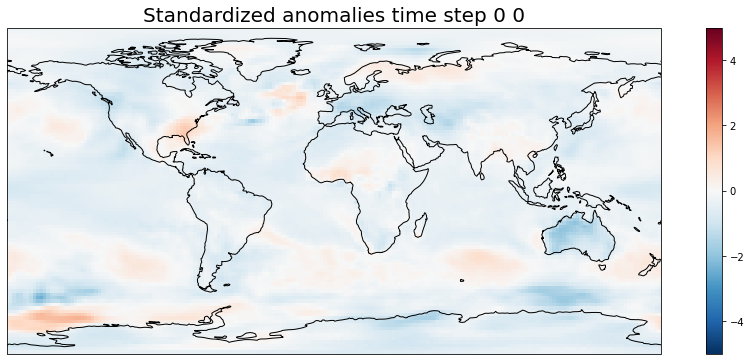

In [19]:
fig, ax = plt.subplots(figsize=(16,6), 
                       subplot_kw={"projection": ccrs.PlateCarree()})
ax.coastlines()
plot = ax.pcolormesh(ds.lon, ds.lat, anom_std[t,:,:], 
                     cmap='RdBu_r', 
                     vmin=-5., 
                     vmax=5.)
plt.title('Standardized anomalies time step 0 '+str(t), fontsize=20)
plt.colorbar(plot)